In [1]:
import proplot as plot
import numpy as np
import yaml
import glob

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "WARNING"))

In [12]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE

with open(glob.glob("../runs/run0014_*/config.yaml")[0]) as fp:
    cfg = yaml.safe_load(fp.read())

In [25]:
import tqdm

for _ in tqdm.trange(1):
    seeds = np.random.randint(low=1, high=2**29, size=3)
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            **data,
        )

100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


In [26]:
print(seeds)

[ 92277690  35907357 127827179]


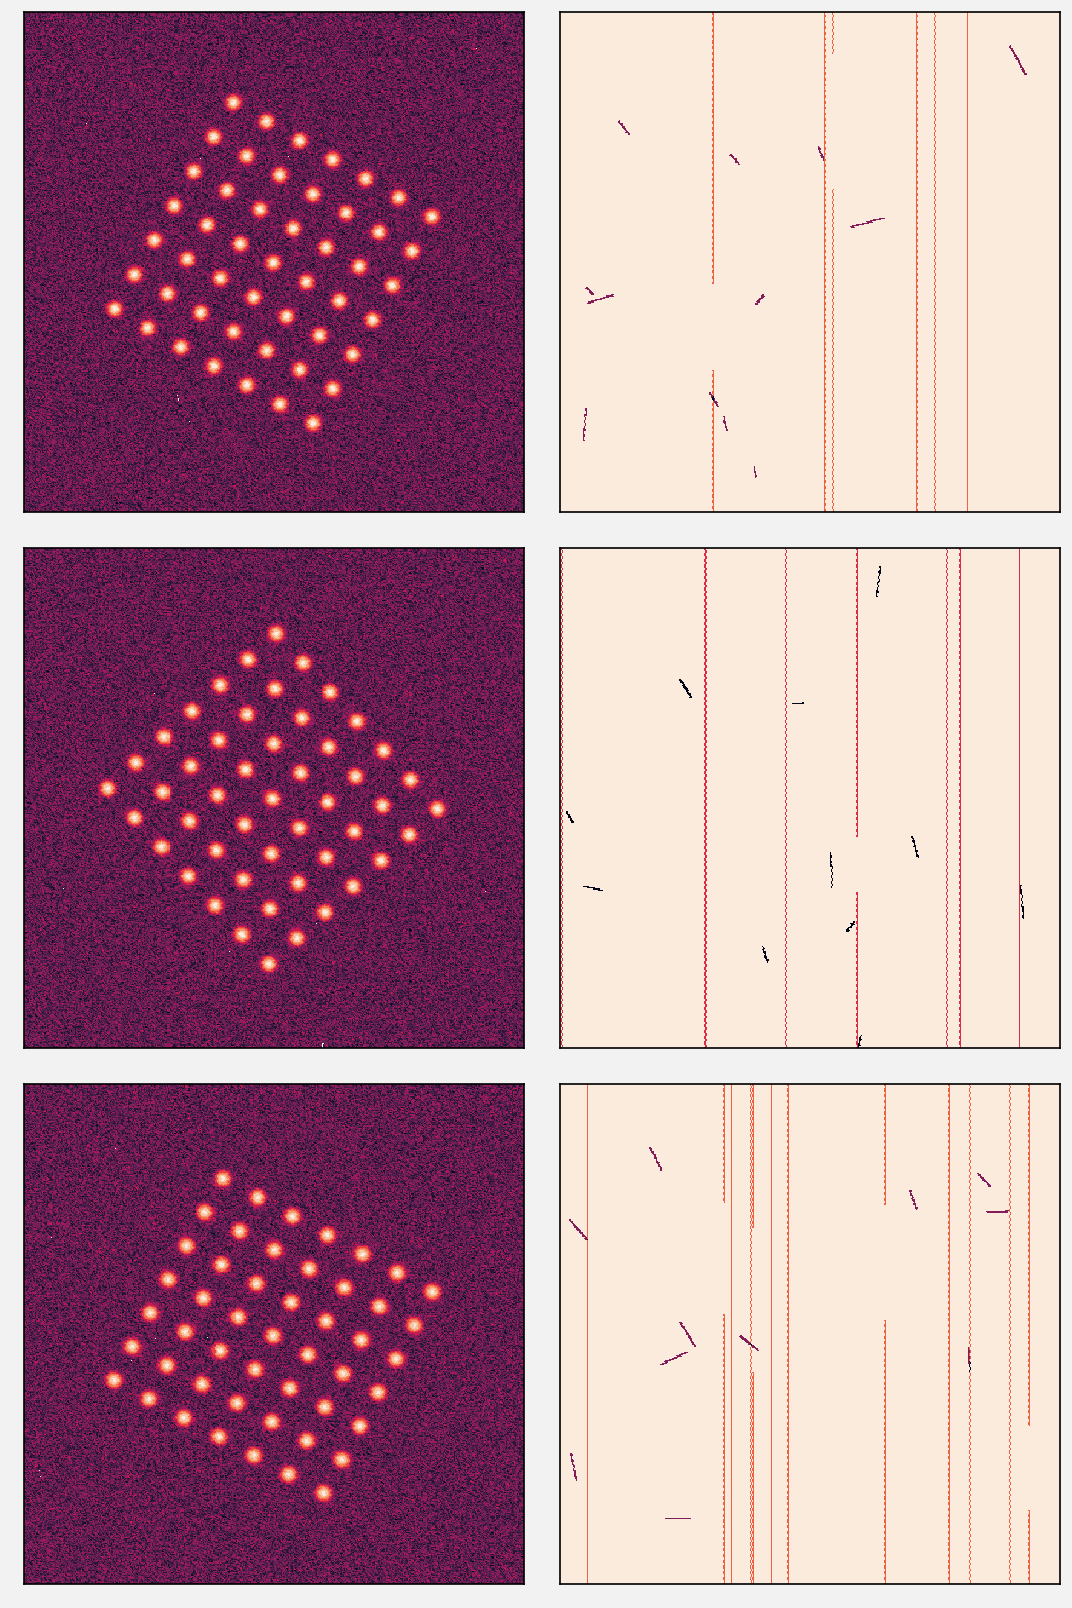

In [27]:
fig, axs = plot.subplots(nrows=len(data["img"]), ncols=2)

for i in range(len(data["img"])):
    axs[i, 0].pcolormesh(np.arcsinh(data["img"][i]*np.sqrt(data["wgt"][i])), cmap="rocket")
    axs[i, 0].set_aspect(1)
    axs[i, 0].xaxis.set_visible(False)
    axs[i, 0].yaxis.set_visible(False)
    axs[i, 1].pcolormesh(data["msk"][i], cmap="rocket_r")
    axs[i, 1].set_aspect(1)
    axs[i, 1].xaxis.set_visible(False)
    axs[i, 1].yaxis.set_visible(False)

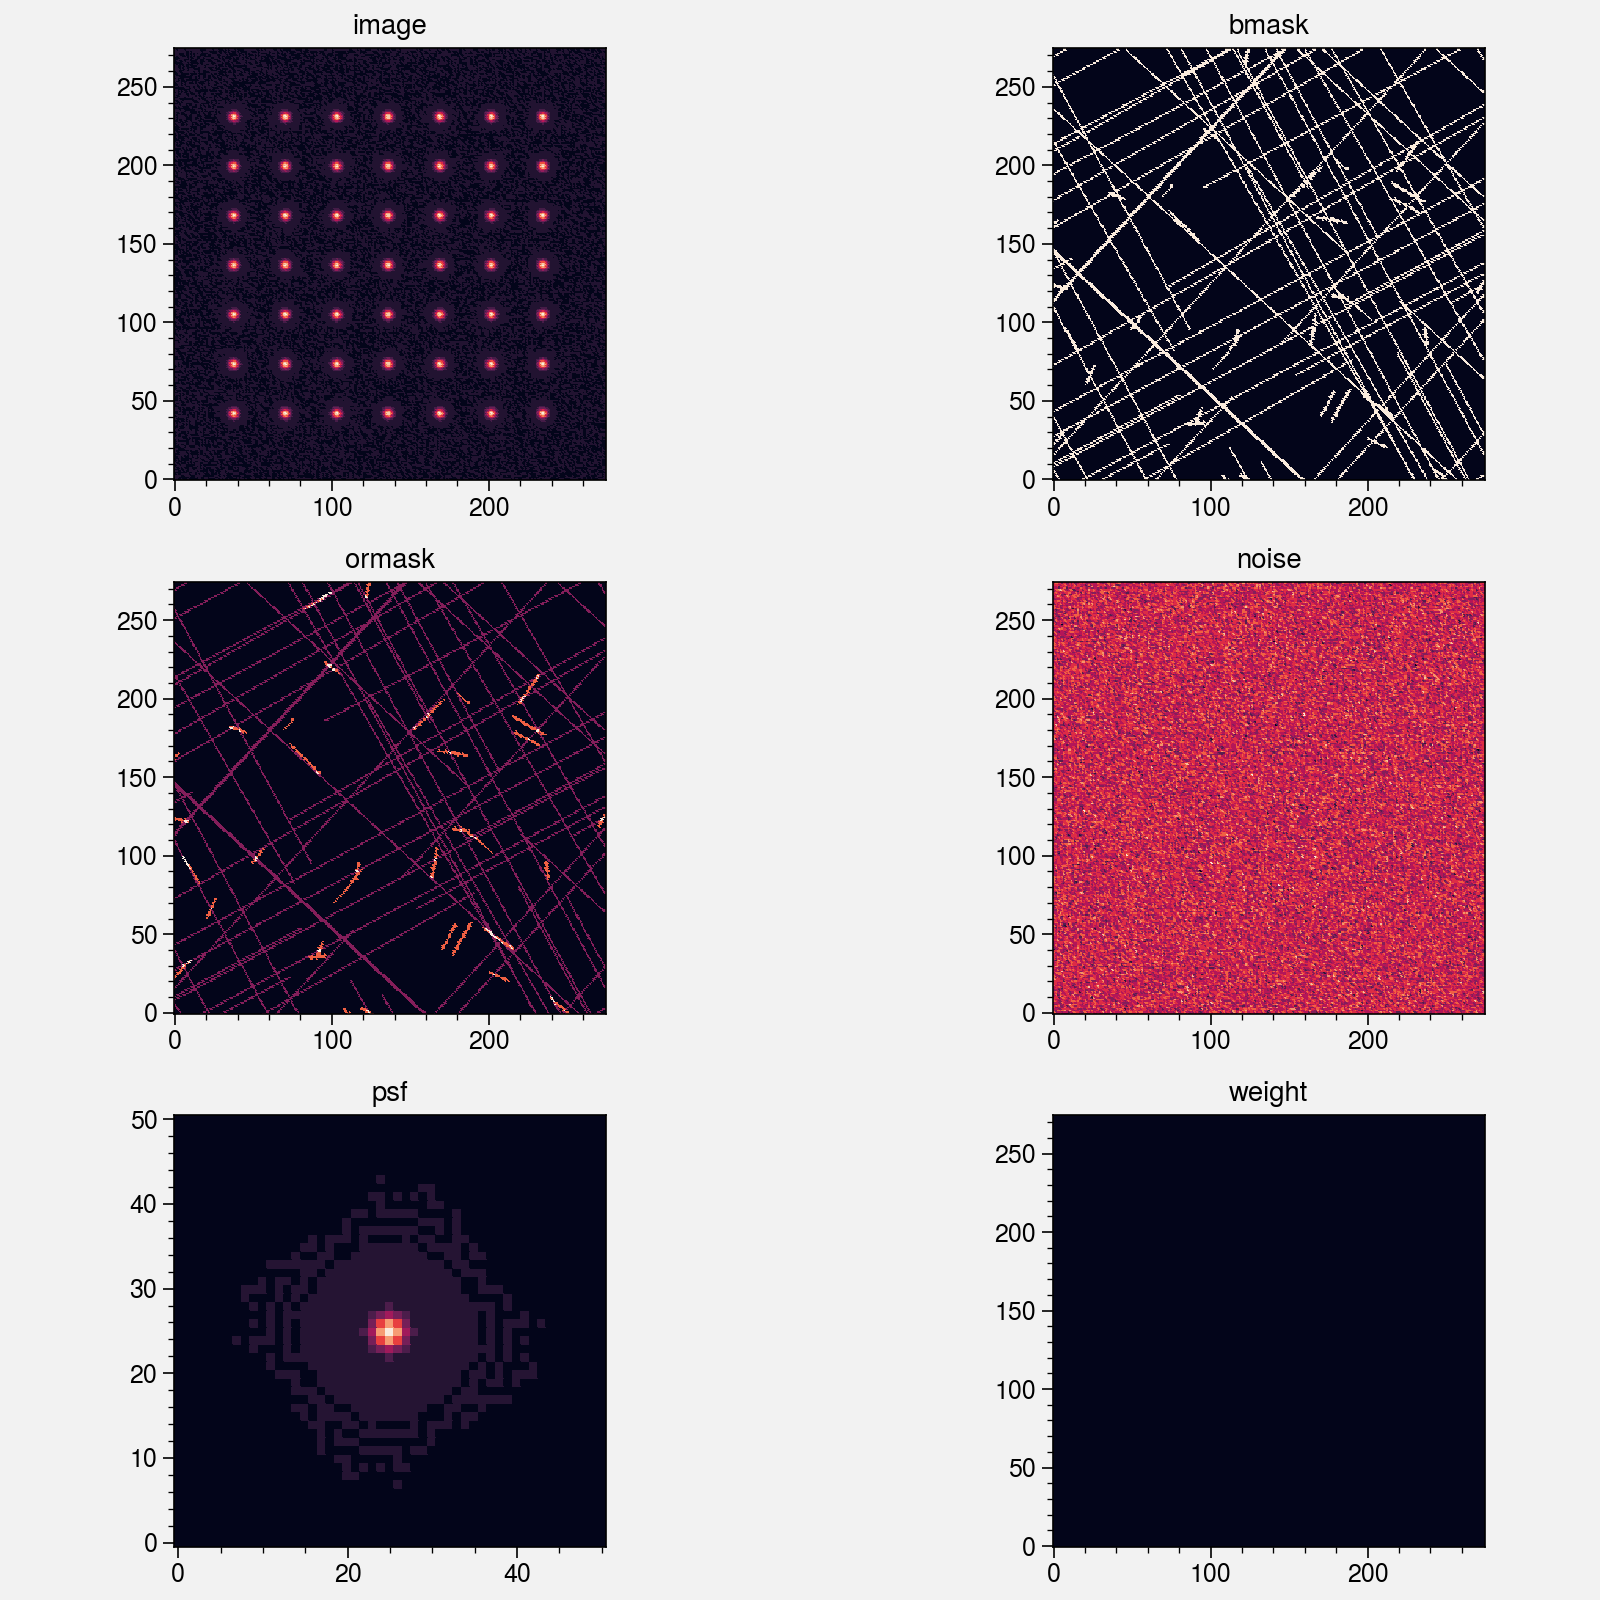

In [28]:
fig, axs = plot.subplots(nrows=3, ncols=2, figsize=(8, 8), share=0)

for i, key in enumerate(["image", "bmask", "ormask", "noise", "psf", "weight"]):
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)

In [29]:
from pizza_cutter_sims.mdet import run_metadetect

mdet_rng = np.random.RandomState(seed=42)
res = run_metadetect(
    rng=mdet_rng,
    config=cfg["metadetect"],
    wcs=data["info"]["affine_wcs"],
    image=cdata["image"],
    bmask=cdata["bmask"],
    ormask=cdata["ormask"],
    noise=cdata["noise"],
    psf=cdata["psf"],
    weight=cdata["weight"],
)


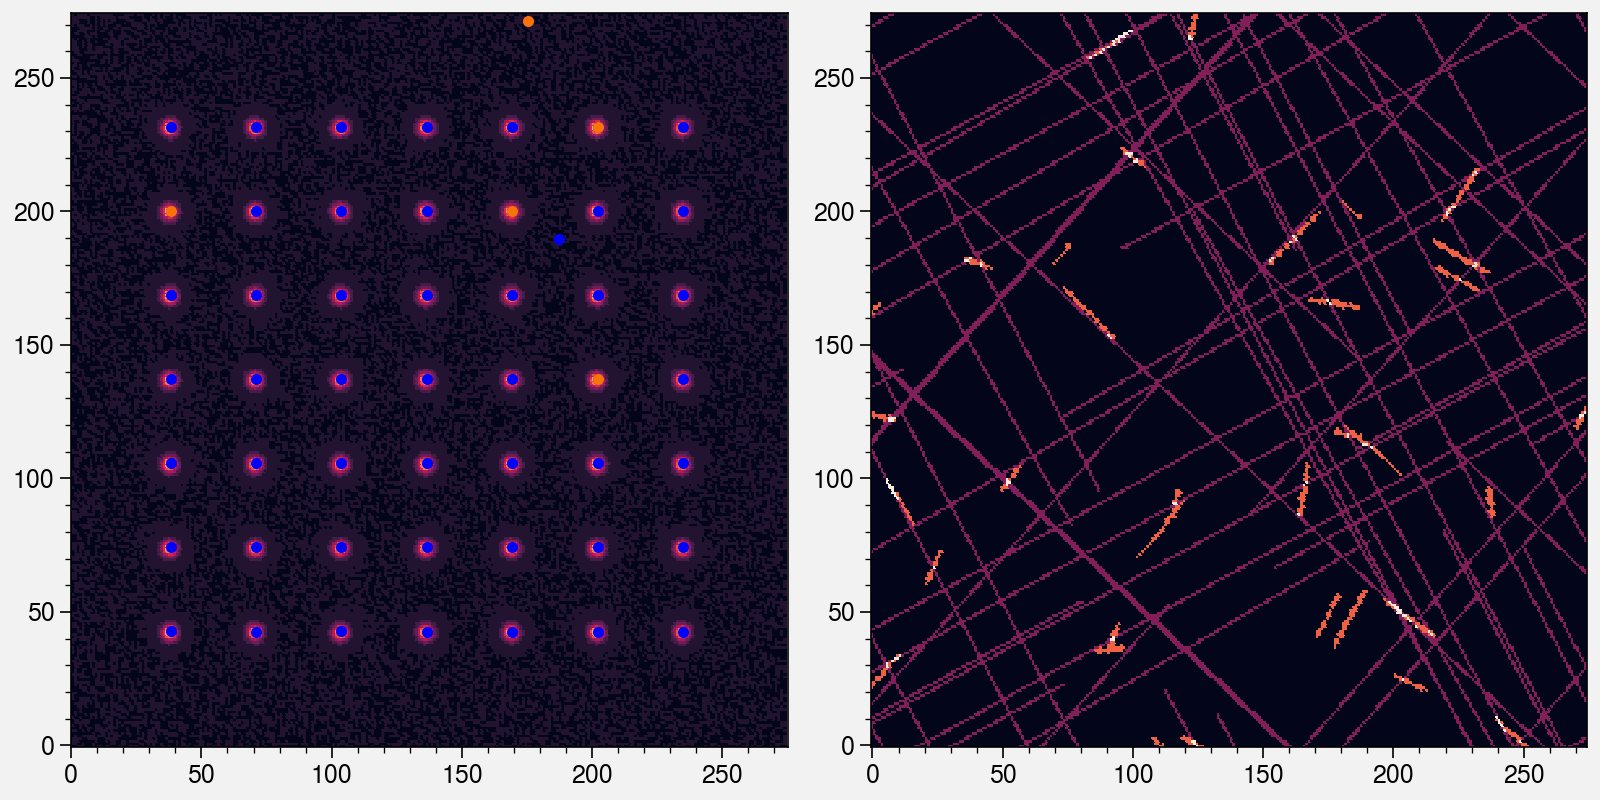

In [30]:
fig, axs = plot.subplots(nrows=1, ncols=2, figsize=(8, 4), share=0)

msk = res["noshear"]["ormask"] != 0

axs[0].pcolormesh(cdata["image"], cmap="rocket")
axs[0].plot(res["noshear"]["sx_col"], res["noshear"]["sx_row"], ".", color="blue")
axs[0].plot(res["noshear"]["sx_col"][msk], res["noshear"]["sx_row"][msk], ".", color="orange")
axs[0].set_xlim(0, cdata["image"].shape[0])
axs[1].pcolormesh(cdata["ormask"], cmap="rocket")